# Restaurant Visitor Forecasting

### 1. Data Preprocessing

In [82]:
import pandas as pd

air_visit = pd.read_csv('data/air_visit_data.csv')
air_reserve = pd.read_csv('data/air_reserve.csv')
hpg_reserve = pd.read_csv('data/hpg_reserve.csv')
air_store_info = pd.read_csv('data/air_store_info.csv')
hpg_store_info = pd.read_csv('data/hpg_store_info.csv')
store_id_relation = pd.read_csv('data/store_id_relation.csv')
date_info = pd.read_csv('data/date_info.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

Converting to datetime format

In [83]:
for df in [air_reserve, hpg_reserve]:
    df['visit_datetime'] = pd.to_datetime(df['visit_datetime']).dt.date
    df['reserve_datetime'] = pd.to_datetime(df['reserve_datetime']).dt.date

air_visit['visit_date'] = pd.to_datetime(air_visit['visit_date']).dt.date
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date

Aggregating Reservation Data
- Total reservations per day
- Average reservation lead time (gap between reservation and visit)

In [84]:
air_reserve['reserve_lead_time'] = (
    pd.to_datetime(air_reserve['visit_datetime']) - 
    pd.to_datetime(air_reserve['reserve_datetime'])
).dt.days

air_agg = air_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'air_reserve_visitors',
    'reserve_lead_time': 'air_reserve_lead_time'
})

In [85]:
hpg_reserve = hpg_reserve.merge(store_id_relation, on='hpg_store_id', how='inner')

hpg_reserve['reserve_lead_time'] = (
    pd.to_datetime(hpg_reserve['visit_datetime']) - 
    pd.to_datetime(hpg_reserve['reserve_datetime'])
).dt.days

hpg_agg = hpg_reserve.groupby(['air_store_id', 'visit_datetime']).agg({
    'reserve_visitors': 'sum',
    'reserve_lead_time': 'mean'
}).reset_index().rename(columns={
    'visit_datetime': 'visit_date',
    'reserve_visitors': 'hpg_reserve_visitors',
    'reserve_lead_time': 'hpg_reserve_lead_time'
})

Creating the modeling base table

In [86]:
# Merge visitor data with reservation features
full_df = air_visit.merge(air_agg, on=['air_store_id', 'visit_date'], how='left')
full_df = full_df.merge(hpg_agg, on=['air_store_id', 'visit_date'], how='left')

# Merge with restaurant metadata
full_df = full_df.merge(air_store_info, on='air_store_id', how='left')

# Merge with calendar features
date_info = date_info.rename(columns={'calendar_date': 'visit_date'})
full_df = full_df.merge(date_info, on='visit_date', how='left')

# Add weekday and weekend features
full_df['day_of_week'] = pd.to_datetime(full_df['visit_date']).dt.dayofweek
full_df['is_weekend'] = full_df['day_of_week'].isin([5, 6]).astype(int)

In [87]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,is_weekend
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2,0,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,0,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,4,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,5,0,1
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,0,0,0


### 2. Lag + Rolling Features

In [88]:
full_df = full_df.sort_values(['air_store_id', 'visit_date'])

In [89]:
# Set number of days to lag
lag_days = [1, 7, 14]

for lag in lag_days:
    full_df[f'visitors_lag_{lag}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(lag)
    )

In [90]:
rolling_windows = [3, 7, 14]

for window in rolling_windows:
    full_df[f'visitors_roll_mean_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)  # ensure that we're not using today’s visitor count to predict itself (no leakage)
        .rolling(window)
        .mean()
        .reset_index(0, drop=True)
    )
    
    full_df[f'visitors_roll_std_{window}'] = (
        full_df
        .groupby('air_store_id')['visitors']
        .shift(1)
        .rolling(window)
        .std()
        .reset_index(0, drop=True)
    )

In [91]:
full_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87534,air_00a91d42b08b08d9,2016-07-01,35,NaN,NaN,1.0,1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,NaN,NaN,NaN,49.000000,6.082763,47.285714,7.994045,52.428571,38.679580
87535,air_00a91d42b08b08d9,2016-07-02,9,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,1,35.0,NaN,NaN,49.333333,5.859465,48.571429,6.900656,53.214286,38.431114
87536,air_00a91d42b08b08d9,2016-07-04,20,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,9.0,NaN,NaN,37.666667,24.378953,42.000000,15.362291,41.000000,14.277470
87537,air_00a91d42b08b08d9,2016-07-05,25,NaN,NaN,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,20.0,NaN,NaN,36.000000,22.605309,44.000000,15.513435,42.571429,14.064217
87538,air_00a91d42b08b08d9,2016-07-06,29,NaN,NaN,7.0,12.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,...,0,25.0,NaN,NaN,38.333333,24.583192,44.142857,15.614401,45.357143,11.875036


### 3. LightGBM Model Setup (Backbone Model)

In [92]:
full_df = full_df[~full_df['visitors'].isna()] # Drop rows with missing target (if any)

In [93]:
target = 'visitors'

# Drop columns we won't use or that leak information
drop_cols = ['visit_date', 'visitors']  # we keep 'air_store_id' for now, might encode

# Get all feature columns
features = [col for col in full_df.columns if col not in drop_cols]

In [94]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical columns

for col in ['air_store_id', 'air_genre_name', 'air_area_name']:
    le = LabelEncoder()
    full_df[col] = le.fit_transform(full_df[col].astype(str))

categorical_features = ['air_store_id', 'air_genre_name', 'air_area_name']

Why Use 2017-03-01 as the cutoff_date?

The data covers:
- Training range: from 2016-01-01 to 2017-04-22
- Test range: late April 2017 to May 2017 (includes Golden Week)

I picked a validation window that:
- Mimics the real test period (late April–May)
- Gives at least 1–2 months of “unseen future” for validation
- Leaves enough history to train LightGBM (over a year of training data)

2017-03-01 gives ~1.5 months of validation data from March to April 22

In [95]:
# Train-Test Split (Time-based)
# Use last N days as validation set
full_df['visit_date'] = pd.to_datetime(full_df['visit_date'])  # Convert to Timestamp

cutoff_date = pd.to_datetime('2017-03-01')
train_df = full_df[full_df['visit_date'] < cutoff_date]
valid_df = full_df[full_df['visit_date'] >= cutoff_date]

In [96]:
import lightgbm as lgb

train_set = lgb.Dataset(train_df[features], label=train_df[target], categorical_feature=categorical_features)
valid_set = lgb.Dataset(valid_df[features], label=valid_df[target], categorical_feature=categorical_features)

In [97]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1
}

lgb_model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 10.4999	valid_1's rmse: 12.7305
[200]	training's rmse: 10.0871	valid_1's rmse: 12.5096
[300]	training's rmse: 9.85345	valid_1's rmse: 12.4725
Early stopping, best iteration is:
[304]	training's rmse: 9.84606	valid_1's rmse: 12.4695


| Metric    | Best For |
| -------- | ------- |
| RMSE  | General-purpose numeric prediction    |
| RMSLE  | Counts, skewed distributions, penalizing underestimates more than overestimates (better for demand forecasting)    |

In [98]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = valid_df[target]
y_pred = lgb_model.predict(valid_df[features])
y_pred = np.clip(y_pred, 0, None)  # No negative visitor predictions

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Validation RMSLE: {rmsle:.4f}")

Validation RMSLE: 0.5374


Plotting Feature Importance

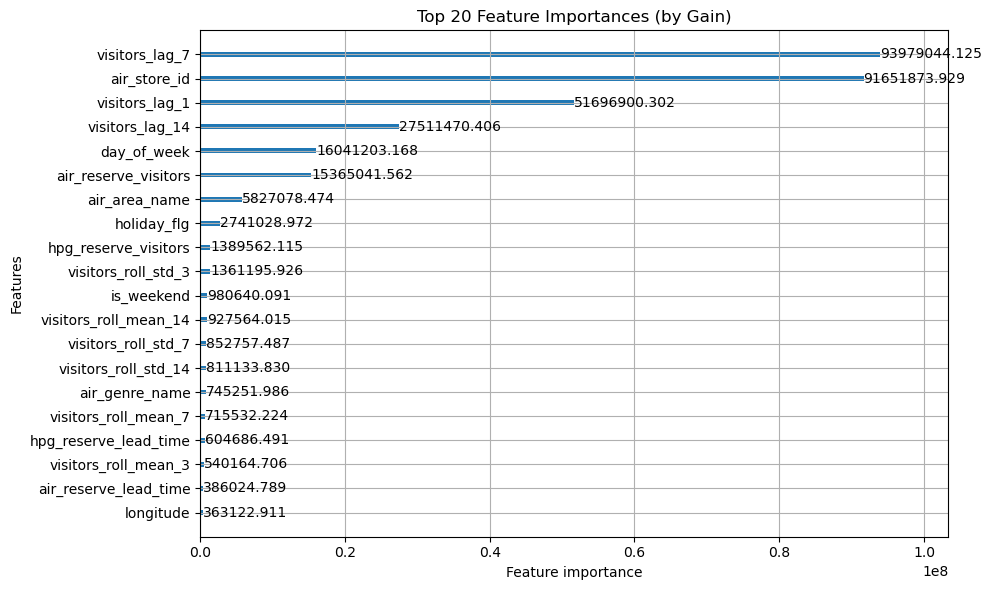

In [99]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

### 4. Integrating Prophet

In [100]:
from prophet import Prophet

In [101]:
# Count non-NaN visitors per store
store_counts = full_df.groupby('air_store_id')['visitors'].apply(lambda x: x.notna().sum()).sort_values(ascending=False)

# Pick a store with at least 50 non-NaN entries
valid_store_id = store_counts[store_counts >= 50].index[0]
print(f"Using store: {valid_store_id}")

Using store: 274


In [102]:
holidays = date_info[date_info['holiday_flg'] == 1][['visit_date']].rename(columns={
    'visit_date': 'ds'
})
holidays['holiday'] = 'japan_holiday'

In [103]:
store_df = full_df[(full_df['air_store_id'] == valid_store_id) & (full_df['visitors'].notnull())].copy()

prophet_df = store_df[['visit_date', 'visitors']].rename(columns={
    'visit_date': 'ds',
    'visitors': 'y'
})

In [104]:
print(prophet_df.head())
print(prophet_df['y'].notna().sum(), "non-NaN values in 'y'")

               ds   y
158602 2016-01-02  24
158603 2016-01-03  49
158604 2016-01-04  10
158605 2016-01-05   2
158606 2016-01-06   9
477 non-NaN values in 'y'


In [105]:
m = Prophet(
    holidays=holidays,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m.fit(prophet_df)

20:16:24 - cmdstanpy - INFO - Chain [1] start processing
20:16:24 - cmdstanpy - INFO - Chain [1] done processing


In [106]:
# Get number of future days to forecast (from your validation set)
forecast_horizon = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()

# Create future dataframe for Prophet
future = m.make_future_dataframe(periods=forecast_horizon)

# Generate forecast
forecast = m.predict(future)

In [107]:
# Merge Prophet forecast with actual validation data
store_forecast = forecast[['ds', 'yhat']].merge(
    valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']],
    left_on='ds',
    right_on='visit_date',
    how='inner'
)

In [108]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = store_forecast['visitors']
y_pred = np.clip(store_forecast['yhat'], 0, None)  # Remove negative predictions

prophet_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Prophet RMSLE for {valid_store_id}: {prophet_rmsle:.4f}")

Prophet RMSLE for 274: 0.4460


### 5. Testing ARIMA

In [109]:
from statsmodels.tsa.arima.model import ARIMA

# Use the same store
arima_df = full_df[(full_df['air_store_id'] == valid_store_id)].copy()
arima_df = arima_df[['visit_date', 'visitors']].dropna()
arima_df = arima_df.set_index('visit_date').asfreq('D')  # Ensure daily frequency

In [110]:
arima_df['visitors'] = arima_df['visitors'].fillna(0)

In [111]:
arima_model = ARIMA(arima_df['visitors'], order=(5,1,0))
arima_model_fit = arima_model.fit()

In [112]:
n_days = valid_df[valid_df['air_store_id'] == valid_store_id]['visit_date'].nunique()
arima_forecast = arima_model_fit.forecast(steps=n_days)

In [113]:
actual = valid_df[valid_df['air_store_id'] == valid_store_id][['visit_date', 'visitors']].copy().reset_index(drop=True)
actual['arima_pred'] = np.clip(arima_forecast.values, 0, None)

In [114]:
from sklearn.metrics import mean_squared_log_error

arima_rmsle = np.sqrt(mean_squared_log_error(actual['visitors'], actual['arima_pred']))
print(f"ARIMA RMSLE for {valid_store_id}: {arima_rmsle:.4f}")

ARIMA RMSLE for 274: 0.6662


| Model    | RMSLE | Interpretation |
| -------- | ------- |  ------- |
| Prophet  | 0.4460    | Captures holiday + seasonal patterns effectively|
| RMSLE  | 0.6662  |  Struggles to generalize — likely overfits short-term noise  |

## 6. LightGBM + Prophet Ensemble

In [115]:
valid_df.head()

,air_store_id,visit_date,visitors,air_reserve_visitors,air_reserve_lead_time,hpg_reserve_visitors,hpg_reserve_lead_time,air_genre_name,air_area_name,latitude,...,is_weekend,visitors_lag_1,visitors_lag_7,visitors_lag_14,visitors_roll_mean_3,visitors_roll_std_3,visitors_roll_mean_7,visitors_roll_std_7,visitors_roll_mean_14,visitors_roll_std_14
87722,0,2017-03-01,17,3.0,11.0,4.0,11.0,6,44,35.694003,...,0,19.0,36.0,24.0,30.666667,6.658328,25.000000,8.755950,29.500000,8.899006
87723,0,2017-03-02,33,NaN,NaN,2.0,1.0,6,44,35.694003,...,0,17.0,33.0,41.0,34.666667,11.503623,29.857143,9.719886,29.928571,9.563265
87724,0,2017-03-03,29,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,33.0,40.0,52.0,42.333333,6.350853,34.142857,9.191093,30.785714,10.452667
87725,0,2017-03-04,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,1,29.0,28.0,35.0,34.000000,20.784610,31.285714,13.009154,29.642857,11.803566
87726,0,2017-03-06,18,NaN,NaN,NaN,NaN,6,44,35.694003,...,0,18.0,11.0,45.0,33.333333,20.231988,34.000000,13.453624,30.214286,12.317458


In [116]:
# Get LightGBM predictions for the store
store_valid = valid_df[valid_df['air_store_id'] == valid_store_id].copy()
store_valid['lgb_pred'] = lgb_model.predict(store_valid[features])

In [117]:
# Already renamed earlier
prophet_forecast = forecast[['ds', 'yhat']].rename(columns={
    'ds': 'visit_date',
    'yhat': 'prophet_pred'
})

In [118]:
ensemble_df = store_valid.merge(prophet_forecast, on='visit_date', how='inner')

In [153]:
alpha = 0.73  # LightGBM weight
ensemble_df['ensemble_pred'] = (
    alpha * ensemble_df['lgb_pred'] + (1 - alpha) * ensemble_df['prophet_pred']
)

In [154]:
from sklearn.metrics import mean_squared_log_error
import numpy as np

y_true = ensemble_df['visitors']
y_pred = np.clip(ensemble_df['ensemble_pred'], 0, None)

ensemble_rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Ensemble RMSLE for {valid_store_id}: {ensemble_rmsle:.4f}")

Ensemble RMSLE for 274: 0.4241


| RMSLE Score    | Interpretation                           |
| --------       | -------                                  |
| < 0.4          | Excellent — very tight predictions       |
| 0.4–0.6        | Solid performance                        |
| > 0.6          | Needs improvement or more feature tuning |
